In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_score, f1_score, recall_score
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, QuantileTransformer
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
import xgboost as xgb
import lightgbm as lgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# from dython.nominal import associations

df=pd.read_excel('C:/Users/PREDATOR/PycharmProjects/Study/MIF/MarginalUpd.xlsx')
df["FLAG_BAD"] = np.where((df["ever30plus"] == 'a. Ever 30Plus') | (df["FlagNegCust"] == '1. NegativeCustomer') , 1, 0)

cats_cols = ['PersonalType','Gender','MaritalStatus', 'ResidenceCompanyProvince', 'HomeCompanyStatus',
            'Pekerjaan','jabatan','Status_pekerjaan','Jenis_pekerjaan2', 'Pendidikan','HomeFixedLine',
            'KantorFixedLine','Wayofpayment','IsSyariah','ProductType','UsedNew', 'GroupProductId',
            'applicationsource','FirstInstallment','AssetCategory','AssetUsage','MainCoverage', 'GRPNTF',
            'GRPOTR','Bidang_usaha','flagImpact','isoveride', 'ProductOffering', 'GRPDP', 'SektorEkonomi',
            'SupplierType', 'SupplierCategory','InstallmentScheme','AssetType','AssetCategoryId','FlagMerkPopular',
            'MadeIn','isKPM','Jenis_KPM', 'jenispinjaman', 'PaymentMethod','FlagRO','JarakDomisili','FlagNegCust',
            'CompanyCity','ResidenceCompanyCity', 'Nama_Perusahaan','Supplier','ResidenceCompanyZipCode','CompanyZipCode']
num_cols = [ 'Lama_Menempati_Tahun','Lama_Menempati_Bulan', 'employmentsinceyear',
             'NumOfDependence', 'NTFIDR', 'TotalOTR', 'Pendapatan', 
            'DPPercentage', 'CAMOSObligorExposure', 'StartingBalance', 'AvgDebit', 'TotalLamaPernahBekerja',
            'AvgCredit','AvgBalance', 'LastBalanceAmt','GrowthBalance', 'jmltunggakanpokok','jmltunggakanhari']

target_var=['FLAG_BAD']
all_var = cats_cols + num_cols + target_var

df = df[df.columns[df.columns.isin(all_var)]]

X = df.drop("FLAG_BAD",axis=1)
y = df["FLAG_BAD"]
  

In [2]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

<ipython-input-2-6dacdb3ef330>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # or 199


In [3]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=123, stratify = y,shuffle=True)

In [4]:
class fillCatsNA(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y = None):
    X_data = X.copy()

    X_data['jenispinjaman'] = X_data['jenispinjaman'].fillna(value='-')
    X_data['JarakDomisili'] = X_data['JarakDomisili'].fillna(value = 'Kurang atau Sama Dengan 60 KM')

    X_data = X_data.apply(lambda x: x.fillna(x.value_counts().index[0]))

    return X_data 

In [5]:
class ConvertData(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    X_data = X.copy()

    X_data['TotalLamaPernahBekerja'] = X_data['TotalLamaPernahBekerja'].fillna(value = 0)

    def repeated(string):
      for x in range(1, len(string)):
        substring = string[:x]
        if substring * (len(string)//len(substring))+(substring[:len(string)%len(substring)]) == string:
          return substring
        elif (string == '2015'):
          return '215'
        elif (string == '2016'):
          return '216'
        elif (string == '1994'):
          return '228'
        elif (string =='21552263233'):
          return '1'
        else :
          return string[0:3]

      return string

    X_data['TotalLamaPernahBekerja'] = X_data['TotalLamaPernahBekerja'].astype(str)
    X_data['TotalLamaPernahBekerja'] = X_data['TotalLamaPernahBekerja'].str.extract('(\d+)')
    X_data['TotalLamaPernahBekerja'] = X_data['TotalLamaPernahBekerja'].astype(str)
    X_data['TotalLamaPernahBekerja'] = X_data['TotalLamaPernahBekerja'].apply(repeated)
    X_data['TotalLamaPernahBekerja'] = X_data['TotalLamaPernahBekerja'].astype(float)

    return X_data

In [6]:
from sklearn.feature_selection._base import SelectorMixin
from sklearn.utils.sparsefuncs import mean_variance_axis, min_max_axis
from sklearn.utils.validation import check_is_fitted
from sklearn.utils._tags import _safe_tags
from sklearn.utils import (
    check_array,
    safe_mask,
    safe_sqr,
)
class ReverseVarianceThreshold(SelectorMixin, BaseEstimator):

  def __init__(self, threshold=0.0):
    self.threshold = threshold

  def fit(self, X, y=None):

    X = self._validate_data(
        X,
        accept_sparse=("csr", "csc"),
        dtype=np.float64,
        force_all_finite="allow-nan",
    )

    if hasattr(X, "toarray"):  # sparse matrix
      _, self.variances_ = mean_variance_axis(X, axis=0)
      if self.threshold == 0:
        mins, maxes = min_max_axis(X, axis=0)
        peak_to_peaks = maxes - mins
    else:
      self.variances_ = np.nanvar(X, axis=0)
      if self.threshold == 0:
        peak_to_peaks = np.ptp(X, axis=0)

    if self.threshold == 0:
      compare_arr = np.array([self.variances_, peak_to_peaks])
      self.variances_ = np.nanmin(compare_arr, axis=0)
    elif self.threshold < 0.0:
      raise ValueError(f"Threshold must be non-negative. Got: {self.threshold}")

    if np.all(~np.isfinite(self.variances_) | (self.variances_ <= self.threshold)):
      msg = "No feature in X meets the variance threshold {0:.5f}"
      if X.shape[0] == 1:
        msg += " (X contains only one sample)"
      raise ValueError(msg.format(self.threshold))

    return self

  def _get_support_mask(self):
    check_is_fitted(self)

    return self.variances_ < self.threshold

  def transform(self, X):
    X = self._validate_data(
        X,
        dtype=None,
        accept_sparse="csr",
        force_all_finite=not _safe_tags(self, key="allow_nan"),
        reset=False,
    )
    return self._transform(X)

  def _transform(self, X):
    mask = self.get_support()
    if not mask.any():
      warn(
          "No features were selected: either the data is"
          " too noisy or the selection test too strict.",
          UserWarning,
      )
      return np.empty(0).reshape((X.shape[0], 0))
    if len(mask) != X.shape[1]:
      raise ValueError("X has a different shape than during fitting.")
    return X[:, safe_mask(X, mask)]

In [7]:
class DropCorrelation(BaseEstimator, TransformerMixin):
  def __init__(self, threshold):
    self.threshold = threshold
    self.col_corr = None
  
  def fit(self, X, y = None):
    col_corr = set()
    X = pd.DataFrame(X)
    X['FLAG_BAD'] = y
    corr_matrix = X.corr()
    target_loc = corr_matrix.columns.get_loc("FLAG_BAD")
    for i in range(len(corr_matrix.columns)):
      for j in range(i):
        if abs(corr_matrix.iloc[i, j])> self.threshold:
          if (abs(corr_matrix.iloc[i, target_loc]) < abs(corr_matrix.iloc[j, target_loc])):
            colname = corr_matrix.columns[j]
            col_corr.add(colname)
          else:
            colname = corr_matrix.columns[i]
            col_corr.add(colname)
    
    # col_corr.add('FLAG_BAD')
    self.col_corr = col_corr

    return self
  
  def transform(self, X, y=None, **kwargs):
    return (pd.DataFrame(X)).drop(labels = self.col_corr, axis=1)

In [8]:
models = {
    #'GaussianNB' : GaussianNB(),
    #'LogisticRegression' : LogisticRegression(fit_intercept = True, solver = 'saga', max_iter = 5000),
    #'RandomForestClassifier' : RandomForestClassifier(n_estimators=100, bootstrap = True, oob_score = True),
    #'XGBClassifier' : xgb.XGBClassifier(objective="binary:logistic"),
    #'AdaBoostClassifier' : AdaBoostClassifier(),
    'LGBMClassifier' : lgb.LGBMClassifier()
}

In [9]:
# model_score = pd.DataFrame(
#     columns = ['Model Name','Train Accuracy','Test Accuracy','ROC Value','Precision','Recall','F1 Score'])

# cat_transformer = Pipeline(
#     steps=[('imputer', fillCatsNA()),
#           ('encoder', ce.WOEEncoder(cols = cats_cols)),
#           ('encoder2', OrdinalEncoder()),
#           ('vt1', ReverseVarianceThreshold(threshold = 100)),
#           ('vt2', VarianceThreshold(threshold = 0.01))]
# )

# num_transformer = Pipeline(
#     steps = [('convert', ConvertData()),
#               ('imputer', SimpleImputer(missing_values = np.nan, strategy='constant', fill_value=0.0)),
#               ('scaler', QuantileTransformer(output_distribution='normal', n_quantiles = 100000))]
# )

# preprocessor = ColumnTransformer(
#     transformers=[('num', num_transformer, num_cols),
#                   ('cats', cat_transformer, cats_cols)]
# )

# for key in models:
#   pipe = Pipeline(
#       steps=[('preprocessor',preprocessor),
#              ('dropcorr',DropCorrelation(0.9)),
#              ('features',SelectKBest(mutual_info_classif, k=20)),
#              ('model', models[key])]
#   )



In [10]:
model_score = pd.DataFrame(
    columns = ['Model Name','Train Accuracy','Test Accuracy','ROC Value','Precision','Recall','F1 Score'])

cat_transformer = Pipeline(
  steps=[('imputer', fillCatsNA()),
        ('encoder2', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
        ('vt1', ReverseVarianceThreshold(threshold = 100)),
        ('vt2', VarianceThreshold(threshold = 0.01)),
        ('encoder', ce.WOEEncoder())
        ]
)

num_transformer = Pipeline(
    steps = [('convert', ConvertData()),
              ('imputer', SimpleImputer(missing_values = np.nan, strategy='constant', fill_value=0.0)),
              ('scaler', QuantileTransformer(output_distribution='normal', n_quantiles = 100000))]
)

preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_cols),
                  ('cats', cat_transformer, cats_cols)]
)

for key in models:
  pipe = Pipeline(
      steps=[('preprocessor',preprocessor),
             ('dropcorr',DropCorrelation(0.9)),
             ('features',SelectKBest(mutual_info_classif, k=20)),
             ('model', models[key])]
  )

In [58]:
#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=42, stratify = y,shuffle=True)
#testing=pipe['preprocessor'].fit_transform(X_train, y_train)

In [ ]:
#testing.head()

In [11]:
  model = pipe.fit(X_train, y_train)
  y_preds = model.predict(X_test)
  y_probs = model.predict_proba(X_test)[:, 1] 

  row = {
      'Model Name': key,
      'Train Accuracy' : (1 - (1 - model.score(X_train, y_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))),
      'Test Accuracy' : (1 - (1 - model.score(X_test, y_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))),
      'ROC Value' : roc_auc_score(y_test,y_probs),
      'Precision' : precision_score(y_test,y_preds),
      'Recall' : recall_score(y_test, y_preds),
      'F1 Score' : f1_score(y_test, y_preds)
    }

  model_score = model_score.append(row, ignore_index = True)

In [22]:
# model_score = pd.DataFrame(
#     columns = ['Model Name','Train Accuracy','Test Accuracy','ROC Value','Precision','Recall','F1 Score'])
# model_score = model_score.append(row, ignore_index = True)

In [12]:
model_score.set_index("Model Name", inplace = True)
model_score = model_score.T
model_score['Best Score'] = model_score.idxmax(axis=1)
model_score.to_excel('ModelsScore.xlsx')
# model_score.to_csv('ModelScore.csv')
model_score

Model Name,LGBMClassifier,Best Score
Train Accuracy,0.901713,LGBMClassifier
Test Accuracy,0.897190,LGBMClassifier
ROC Value,0.768654,LGBMClassifier
Precision,0.533898,LGBMClassifier
Recall,0.055336,LGBMClassifier
F1 Score,0.100279,LGBMClassifier


In [13]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('convert',
                                                                   ConvertData()),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0.0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   QuantileTransformer(n_quantiles=100000,
                                                                                       output_distribution='normal'))]),
                                                  ['Lama_Menempati_Tahun',
                                                   'Lama_Menempati_Bulan',
               

In [14]:
#cek full kategorikal
len(X_train[cats_cols].columns)

50

In [15]:
#cek pipeline sampai vt1
model[0].transformers_[1][1][0:3]

Pipeline(steps=[('imputer', fillCatsNA()),
                ('encoder2',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('vt1', ReverseVarianceThreshold(threshold=100))])

In [16]:
#cek transform sampe vt1, jumlah kolom ke drop apa enggak
pd.DataFrame(model[0].transformers_[1][1][0:3].transform(X_train[cats_cols])).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,1.0,0.0,2.0,4.0,8.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,8.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0,1.0
1,0.0,1.0,2.0,4.0,13.0,3.0,2.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,12.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0,1.0
2,0.0,0.0,4.0,0.0,12.0,2.0,2.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,12.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0
3,0.0,0.0,2.0,4.0,5.0,2.0,2.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,19.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0
4,1.0,1.0,2.0,4.0,8.0,3.0,5.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,8.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0,1.0


In [17]:
#cek kategorikal yg di drop di vt1
X_train[cats_cols].loc[:,~model[0].transformers_[1][1][2].get_support()].columns

Index(['ResidenceCompanyProvince', 'Pekerjaan', 'Bidang_usaha',
       'ProductOffering', 'SektorEkonomi', 'CompanyCity',
       'ResidenceCompanyCity', 'Nama_Perusahaan', 'Supplier',
       'ResidenceCompanyZipCode', 'CompanyZipCode'],
      dtype='object')

In [18]:
#cek kategorikal yg di drop di vt1, pakai itertool lebih sederhana
from itertools import compress
list(compress(cats_cols, ~model[0].transformers_[1][1][2].get_support()))

['ResidenceCompanyProvince',
 'Pekerjaan',
 'Bidang_usaha',
 'ProductOffering',
 'SektorEkonomi',
 'CompanyCity',
 'ResidenceCompanyCity',
 'Nama_Perusahaan',
 'Supplier',
 'ResidenceCompanyZipCode',
 'CompanyZipCode']

In [19]:
#cek pipeline sampai vt2
model[0].transformers_[1][1][0:4]

Pipeline(steps=[('imputer', fillCatsNA()),
                ('encoder2',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('vt1', ReverseVarianceThreshold(threshold=100)),
                ('vt2', VarianceThreshold(threshold=0.01))])

In [20]:
#cek transform sampe vt2, jumlah kolom ke drop apa enggak
pd.DataFrame(model[0].transformers_[1][1][0:4].transform(X_train[cats_cols])).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.0,0.0,2.0,4.0,8.0,3.0,5.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,8.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0
1,0.0,1.0,2.0,4.0,13.0,3.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,12.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0
2,0.0,0.0,4.0,0.0,12.0,2.0,2.0,8.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,12.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0
3,0.0,0.0,2.0,4.0,5.0,2.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,19.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0
4,1.0,1.0,2.0,4.0,8.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0


In [21]:
#cek kategorikal yg di drop di vt2, harus transform dulu sampe vt1 karena kalo X_train blm transform nanti indexnya gk cocok
#karena vt2 memang di train pake X_train yg udh di transform pakai vt1 (udh ada yg di drop kolomnya)
X_train[X_train[cats_cols].loc[:,model[0].transformers_[1][1][2].get_support()].columns].loc[:,
         ~model[0].transformers_[1][1][3].get_support()].columns

Index(['HomeFixedLine', 'KantorFixedLine', 'AssetType', 'FlagNegCust'], dtype='object')

In [22]:
#cek kategorikal yg di drop di vt2, sama aja ribetnya -__-
a=list(compress(cats_cols, model[0].transformers_[1][1][2].get_support()))
list(compress(a, ~model[0].transformers_[1][1][3].get_support()))

['HomeFixedLine', 'KantorFixedLine', 'AssetType', 'FlagNegCust']

In [23]:
#save kategorikal baru yg udah transform di vt1 dan vt2
kats_cols=list(X_train[X_train[cats_cols].loc[:,model[0].transformers_[1][1][2].get_support()].columns].loc[:,
                         model[0].transformers_[1][1][3].get_support()].columns)

In [24]:
#save kategorikal baru pake itertools
b=list(compress(a, ~model[0].transformers_[1][1][3].get_support()))
kets_cols=list(compress(a, model[0].transformers_[1][1][3].get_support()))

In [25]:
len(kats_cols)==len(kets_cols)

True

In [26]:
#cek full preprocessing
model[0]

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('convert', ConvertData()),
                                                 ('imputer',
                                                  SimpleImputer(fill_value=0.0,
                                                                strategy='constant')),
                                                 ('scaler',
                                                  QuantileTransformer(n_quantiles=100000,
                                                                      output_distribution='normal'))]),
                                 ['Lama_Menempati_Tahun',
                                  'Lama_Menempati_Bulan', 'employmentsinceyear',
                                  'NumOfDependence', 'NTFIDR', 'TotalOTR',
                                  'Pendapatan', 'DPPe...
                                  'HomeCompanyStatus', 'Pekerjaan', 'jabatan',
                                  'Status_pekerjaan

In [27]:
#full preprocessing ada 53 kolom
pd.DataFrame(model[0].transform(X_train)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,-0.154788,-0.155435,-0.582373,-5.199338,1.229559,0.867398,0.959269,-1.889532,-5.199338,0.584973,0.555364,-0.570195,0.528596,0.228564,0.538509,0.124816,-5.199338,-5.199338,1.0,0.0,2.0,4.0,8.0,3.0,5.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,8.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0
1,0.584661,0.583279,0.923487,-5.199338,-0.610085,-0.391663,-0.967402,0.708675,-5.199338,1.599358,0.231472,1.886404,-0.412099,1.505089,1.358384,-0.672658,-5.199338,-5.199338,0.0,1.0,2.0,4.0,13.0,3.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,12.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0
2,0.510564,0.509023,-1.158641,-5.199338,0.459373,0.217128,-0.325917,-1.150683,-5.199338,-1.311876,-0.299776,-1.136129,-0.326234,-1.049642,-0.548271,1.483200,1.415228,2.010480,0.0,0.0,4.0,0.0,12.0,2.0,2.0,8.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,12.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0
3,0.416770,0.415144,0.722374,-5.199338,0.707518,0.799166,-0.098004,0.591336,-5.199338,-0.182095,0.128682,0.724800,-0.053179,-0.838083,-1.087711,-1.362178,-5.199338,-5.199338,0.0,0.0,2.0,4.0,5.0,2.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,19.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0
4,0.206349,0.204659,-1.158641,-5.199338,-0.195006,-0.553508,1.235345,-0.775940,1.553511,2.009157,1.558895,-1.511696,1.230360,1.476979,0.146979,-1.818153,-5.199338,-5.199338,1.0,1.0,2.0,4.0,8.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0


In [28]:
#pipeline full kategorikal
model[0].transformers_[1][1]

Pipeline(steps=[('imputer', fillCatsNA()),
                ('encoder2',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('vt1', ReverseVarianceThreshold(threshold=100)),
                ('vt2', VarianceThreshold(threshold=0.01)),
                ('encoder', WOEEncoder(cols=[]))])

In [29]:
#kategorikal transform ada 35 kolom
model[0].transformers_[1][1].transform(X_train[cats_cols]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1.0,0.0,2.0,4.0,8.0,3.0,5.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,8.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0
1,0.0,1.0,2.0,4.0,13.0,3.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,12.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0
2,0.0,0.0,4.0,0.0,12.0,2.0,2.0,8.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,12.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0
3,0.0,0.0,2.0,4.0,5.0,2.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,19.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0
4,1.0,1.0,2.0,4.0,8.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0


In [30]:
#pipeline kategorikal sampe sebelu vt1
model[0].transformers_[1][1][0:2]

Pipeline(steps=[('imputer', fillCatsNA()),
                ('encoder2',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1))])

In [31]:
#kategorikal sampe sebelum vt1 ada 50
pd.DataFrame(model[0].transformers_[1][1][0:2].transform(X_train[cats_cols]),columns=cats_cols).head()

,PersonalType,Gender,MaritalStatus,ResidenceCompanyProvince,HomeCompanyStatus,Pekerjaan,jabatan,Status_pekerjaan,Jenis_pekerjaan2,Pendidikan,HomeFixedLine,KantorFixedLine,Wayofpayment,IsSyariah,ProductType,UsedNew,GroupProductId,applicationsource,FirstInstallment,AssetCategory,AssetUsage,MainCoverage,GRPNTF,GRPOTR,Bidang_usaha,flagImpact,isoveride,ProductOffering,GRPDP,SektorEkonomi,SupplierType,SupplierCategory,InstallmentScheme,AssetType,AssetCategoryId,FlagMerkPopular,MadeIn,isKPM,Jenis_KPM,jenispinjaman,PaymentMethod,FlagRO,JarakDomisili,FlagNegCust,CompanyCity,ResidenceCompanyCity,Nama_Perusahaan,Supplier,ResidenceCompanyZipCode,CompanyZipCode
0,1.0,0.0,2.0,33.0,4.0,98.0,8.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,65.0,0.0,1.0,84.0,1.0,4.0,0.0,0.0,1.0,0.0,8.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0,1.0,456.0,333.0,25443.0,1511.0,1485.0,1659.0
1,0.0,1.0,2.0,1.0,4.0,44.0,13.0,3.0,2.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,1.0,50.0,0.0,0.0,82.0,4.0,4.0,0.0,0.0,1.0,0.0,12.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0,1.0,623.0,456.0,4344.0,1806.0,231.0,248.0
2,0.0,0.0,4.0,10.0,0.0,44.0,12.0,2.0,2.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,2.0,7.0,1.0,0.0,89.0,2.0,4.0,0.0,0.0,1.0,0.0,12.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,608.0,445.0,38098.0,1021.0,3730.0,4058.0
3,0.0,0.0,2.0,10.0,4.0,44.0,5.0,2.0,2.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,3.0,27.0,1.0,1.0,583.0,3.0,148.0,0.0,0.0,1.0,0.0,19.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,608.0,416.0,43252.0,1450.0,3889.0,4091.0
4,1.0,1.0,2.0,5.0,4.0,98.0,8.0,3.0,5.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,68.0,0.0,1.0,24.0,2.0,148.0,0.0,1.0,1.0,0.0,8.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0,1.0,188.0,137.0,73231.0,1092.0,79.0,5.0


In [32]:
#pipeline full num
model[0].transformers_[0][1]

Pipeline(steps=[('convert', ConvertData()),
                ('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler',
                 QuantileTransformer(n_quantiles=100000,
                                     output_distribution='normal'))])

In [33]:
#cek converter
model[0].transformers_[0][1][0]

ConvertData()

In [34]:
#num ada 18 kolom
model[0].transformers_[0][1][0].transform(X_train[num_cols]).head()

,Lama_Menempati_Tahun,Lama_Menempati_Bulan,employmentsinceyear,NumOfDependence,NTFIDR,TotalOTR,Pendapatan,DPPercentage,CAMOSObligorExposure,StartingBalance,AvgDebit,TotalLamaPernahBekerja,AvgCredit,AvgBalance,LastBalanceAmt,GrowthBalance,jmltunggakanpokok,jmltunggakanhari
11468,10.0,120.0,60,0,321946002.0,383600000,300000000.0,20.069020,0.00,54070240.0,8.559763e+07,60.0,9.432421e+07,4.009498e+07,80249992.0,0.484180,0.0,0
2319,18.0,216.0,216,0,114600980.0,195100000,13197500.0,41.260390,0.00,361923704.0,4.389356e+07,360.0,1.751074e+07,3.215409e+08,282775254.0,-0.218688,0.0,0
37322,17.0,204.0,36,0,187312350.0,249750000,24500000.0,25.000060,0.00,180279.0,1.535562e+07,36.0,2.034651e+07,3.459627e+06,10162053.0,55.368479,1329034.0,1254
79413,16.0,192.0,180,0,215400000.0,359000000,37000000.0,40.000000,0.00,10122926.0,3.574176e+07,180.0,3.310188e+07,5.590689e+06,2203277.0,-0.782348,0.0,0
116669,14.0,168.0,36,0,134940945.0,183000000,500000000.0,26.261779,80595951.78,786632834.0,7.657549e+08,24.0,3.939131e+08,3.081582e+08,42949119.0,-0.945401,0.0,0


In [35]:
#full kategorikal
model[0].transformers_[1][1]

Pipeline(steps=[('imputer', fillCatsNA()),
                ('encoder2',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('vt1', ReverseVarianceThreshold(threshold=100)),
                ('vt2', VarianceThreshold(threshold=0.01)),
                ('encoder', WOEEncoder(cols=[]))])

In [36]:
test1=pd.DataFrame(model[0].transformers_[1][1].transform(X_train[cats_cols]))

In [37]:
test1.columns=kats_cols

In [38]:
#kategorikal full transform
test1.head()

,PersonalType,Gender,MaritalStatus,HomeCompanyStatus,jabatan,Status_pekerjaan,Jenis_pekerjaan2,Pendidikan,Wayofpayment,IsSyariah,ProductType,UsedNew,GroupProductId,applicationsource,FirstInstallment,AssetCategory,AssetUsage,MainCoverage,GRPNTF,GRPOTR,flagImpact,isoveride,GRPDP,SupplierType,SupplierCategory,InstallmentScheme,AssetCategoryId,FlagMerkPopular,MadeIn,isKPM,Jenis_KPM,jenispinjaman,PaymentMethod,FlagRO,JarakDomisili
0,1.0,0.0,2.0,4.0,8.0,3.0,5.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,8.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0
1,0.0,1.0,2.0,4.0,13.0,3.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,12.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0
2,0.0,0.0,4.0,0.0,12.0,2.0,2.0,8.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,12.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0
3,0.0,0.0,2.0,4.0,5.0,2.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,19.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0
4,1.0,1.0,2.0,4.0,8.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0


In [39]:
#kyknya gk ke woe yak, perlu cek lagi
test1['AssetCategoryId'].value_counts()

8.0     43907
19.0    22702
12.0    21189
13.0    5361 
3.0     4325 
11.0    1894 
10.0    1787 
6.0     345  
14.0    313  
5.0     309  
2.0     200  
17.0    137  
21.0    131  
15.0    76   
20.0    54   
7.0     22   
0.0     15   
9.0     8    
1.0     8    
4.0     3    
18.0    1    
16.0    1    
Name: AssetCategoryId, dtype: int64

In [40]:
#numerikal full transform
pd.DataFrame(model[0].transformers_[0][1].transform(X_train[num_cols]),columns=num_cols).head()

,Lama_Menempati_Tahun,Lama_Menempati_Bulan,employmentsinceyear,NumOfDependence,NTFIDR,TotalOTR,Pendapatan,DPPercentage,CAMOSObligorExposure,StartingBalance,AvgDebit,TotalLamaPernahBekerja,AvgCredit,AvgBalance,LastBalanceAmt,GrowthBalance,jmltunggakanpokok,jmltunggakanhari
0,-0.154788,-0.155435,-0.582373,-5.199338,1.229559,0.867398,0.959269,-1.889532,-5.199338,0.584973,0.555364,-0.570195,0.528596,0.228564,0.538509,0.124816,-5.199338,-5.199338
1,0.584661,0.583279,0.923487,-5.199338,-0.610085,-0.391663,-0.967402,0.708675,-5.199338,1.599358,0.231472,1.886404,-0.412099,1.505089,1.358384,-0.672658,-5.199338,-5.199338
2,0.510564,0.509023,-1.158641,-5.199338,0.459373,0.217128,-0.325917,-1.150683,-5.199338,-1.311876,-0.299776,-1.136129,-0.326234,-1.049642,-0.548271,1.483200,1.415228,2.010480
3,0.416770,0.415144,0.722374,-5.199338,0.707518,0.799166,-0.098004,0.591336,-5.199338,-0.182095,0.128682,0.724800,-0.053179,-0.838083,-1.087711,-1.362178,-5.199338,-5.199338
4,0.206349,0.204659,-1.158641,-5.199338,-0.195006,-0.553508,1.235345,-0.775940,1.553511,2.009157,1.558895,-1.511696,1.230360,1.476979,0.146979,-1.818153,-5.199338,-5.199338


In [41]:
#numerikal + kategorikal (preprocessing), abis cocokin sama numerikal full transform dan kategorikal full transform
#keliatannya ke drop, jumlah kolomnya jadi 53 = 18 + 35, diliat cocokin nama kolom 1 1 jg udh cocok angkanya
pd.DataFrame(model.steps[0][1].transform(X_train),columns=num_cols+kats_cols).head()

,Lama_Menempati_Tahun,Lama_Menempati_Bulan,employmentsinceyear,NumOfDependence,NTFIDR,TotalOTR,Pendapatan,DPPercentage,CAMOSObligorExposure,StartingBalance,AvgDebit,TotalLamaPernahBekerja,AvgCredit,AvgBalance,LastBalanceAmt,GrowthBalance,jmltunggakanpokok,jmltunggakanhari,PersonalType,Gender,MaritalStatus,HomeCompanyStatus,jabatan,Status_pekerjaan,Jenis_pekerjaan2,Pendidikan,Wayofpayment,IsSyariah,ProductType,UsedNew,GroupProductId,applicationsource,FirstInstallment,AssetCategory,AssetUsage,MainCoverage,GRPNTF,GRPOTR,flagImpact,isoveride,GRPDP,SupplierType,SupplierCategory,InstallmentScheme,AssetCategoryId,FlagMerkPopular,MadeIn,isKPM,Jenis_KPM,jenispinjaman,PaymentMethod,FlagRO,JarakDomisili
0,-0.154788,-0.155435,-0.582373,-5.199338,1.229559,0.867398,0.959269,-1.889532,-5.199338,0.584973,0.555364,-0.570195,0.528596,0.228564,0.538509,0.124816,-5.199338,-5.199338,1.0,0.0,2.0,4.0,8.0,3.0,5.0,4.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,8.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0
1,0.584661,0.583279,0.923487,-5.199338,-0.610085,-0.391663,-0.967402,0.708675,-5.199338,1.599358,0.231472,1.886404,-0.412099,1.505089,1.358384,-0.672658,-5.199338,-5.199338,0.0,1.0,2.0,4.0,13.0,3.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,12.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0
2,0.510564,0.509023,-1.158641,-5.199338,0.459373,0.217128,-0.325917,-1.150683,-5.199338,-1.311876,-0.299776,-1.136129,-0.326234,-1.049642,-0.548271,1.483200,1.415228,2.010480,0.0,0.0,4.0,0.0,12.0,2.0,2.0,8.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,12.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0
3,0.416770,0.415144,0.722374,-5.199338,0.707518,0.799166,-0.098004,0.591336,-5.199338,-0.182095,0.128682,0.724800,-0.053179,-0.838083,-1.087711,-1.362178,-5.199338,-5.199338,0.0,0.0,2.0,4.0,5.0,2.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,19.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0
4,0.206349,0.204659,-1.158641,-5.199338,-0.195006,-0.553508,1.235345,-0.775940,1.553511,2.009157,1.558895,-1.511696,1.230360,1.476979,0.146979,-1.818153,-5.199338,-5.199338,1.0,1.0,2.0,4.0,8.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,8.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0


In [42]:
len(pd.DataFrame(model.steps[0][1].transform(X_train),columns=num_cols+kats_cols).columns)

53

In [43]:
#semua feature setelah preprocesing sebelum dropkor
dict_feature={k: v for v, k in enumerate(pd.DataFrame(model[0].transform(X_train),columns=num_cols+kats_cols).columns)}
dict_feature = {value:key for key, value in dict_feature.items()}
dict_feature

{0: 'Lama_Menempati_Tahun',
 1: 'Lama_Menempati_Bulan',
 2: 'employmentsinceyear',
 3: 'NumOfDependence',
 4: 'NTFIDR',
 5: 'TotalOTR',
 6: 'Pendapatan',
 7: 'DPPercentage',
 8: 'CAMOSObligorExposure',
 9: 'StartingBalance',
 10: 'AvgDebit',
 11: 'TotalLamaPernahBekerja',
 12: 'AvgCredit',
 13: 'AvgBalance',
 14: 'LastBalanceAmt',
 15: 'GrowthBalance',
 16: 'jmltunggakanpokok',
 17: 'jmltunggakanhari',
 18: 'PersonalType',
 19: 'Gender',
 20: 'MaritalStatus',
 21: 'HomeCompanyStatus',
 22: 'jabatan',
 23: 'Status_pekerjaan',
 24: 'Jenis_pekerjaan2',
 25: 'Pendidikan',
 26: 'Wayofpayment',
 27: 'IsSyariah',
 28: 'ProductType',
 29: 'UsedNew',
 30: 'GroupProductId',
 31: 'applicationsource',
 32: 'FirstInstallment',
 33: 'AssetCategory',
 34: 'AssetUsage',
 35: 'MainCoverage',
 36: 'GRPNTF',
 37: 'GRPOTR',
 38: 'flagImpact',
 39: 'isoveride',
 40: 'GRPDP',
 41: 'SupplierType',
 42: 'SupplierCategory',
 43: 'InstallmentScheme',
 44: 'AssetCategoryId',
 45: 'FlagMerkPopular',
 46: 'MadeIn'

In [44]:
#drop korelasi
list( dict_feature[i] for i in sorted(list(model[1].col_corr)))

['Lama_Menempati_Bulan',
 'LastBalanceAmt',
 'jmltunggakanhari',
 'IsSyariah',
 'GRPOTR',
 'GRPDP',
 'AssetCategoryId']

In [45]:
list( (num_cols+kats_cols)[i] for i in sorted(list(model[1].col_corr)))

['Lama_Menempati_Bulan',
 'LastBalanceAmt',
 'jmltunggakanhari',
 'IsSyariah',
 'GRPOTR',
 'GRPDP',
 'AssetCategoryId']

In [46]:
sorted(list(model[1].col_corr))

[1, 14, 17, 27, 37, 40, 44]

In [47]:
#setelah drop korelasi simpen di aval
allfeat=[x for x in (num_cols+kats_cols) if x not in (list( (num_cols+kats_cols)[i] for i in sorted(list(model.steps[1][1].col_corr))))]
allfeat

['Lama_Menempati_Tahun',
 'employmentsinceyear',
 'NumOfDependence',
 'NTFIDR',
 'TotalOTR',
 'Pendapatan',
 'DPPercentage',
 'CAMOSObligorExposure',
 'StartingBalance',
 'AvgDebit',
 'TotalLamaPernahBekerja',
 'AvgCredit',
 'AvgBalance',
 'GrowthBalance',
 'jmltunggakanpokok',
 'PersonalType',
 'Gender',
 'MaritalStatus',
 'HomeCompanyStatus',
 'jabatan',
 'Status_pekerjaan',
 'Jenis_pekerjaan2',
 'Pendidikan',
 'Wayofpayment',
 'ProductType',
 'UsedNew',
 'GroupProductId',
 'applicationsource',
 'FirstInstallment',
 'AssetCategory',
 'AssetUsage',
 'MainCoverage',
 'GRPNTF',
 'flagImpact',
 'isoveride',
 'SupplierType',
 'SupplierCategory',
 'InstallmentScheme',
 'FlagMerkPopular',
 'MadeIn',
 'isKPM',
 'Jenis_KPM',
 'jenispinjaman',
 'PaymentMethod',
 'FlagRO',
 'JarakDomisili']

In [48]:
#setelah drop korelasi tinggal 48
len(pd.DataFrame(model[0:2].transform(X_train)).columns)

46

In [49]:
#setelah drop korelasi, nama kolomnya gk kereset, makanya perlu dictionary td buat cari kolomnya
pd.DataFrame(model[0:2].transform(X_train)).head()

,0,2,3,4,5,6,7,8,9,10,11,12,13,15,16,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,38,39,41,42,43,45,46,47,48,49,50,51,52
0,-0.154788,-0.582373,-5.199338,1.229559,0.867398,0.959269,-1.889532,-5.199338,0.584973,0.555364,-0.570195,0.528596,0.228564,0.124816,-5.199338,1.0,0.0,2.0,4.0,8.0,3.0,5.0,4.0,0.0,2.0,0.0,0.0,1.0,1.0,8.0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,6.0,1.0,2.0,5.0,2.0,0.0,0.0
1,0.584661,0.923487,-5.199338,-0.610085,-0.391663,-0.967402,0.708675,-5.199338,1.599358,0.231472,1.886404,-0.412099,1.505089,-0.672658,-5.199338,0.0,1.0,2.0,4.0,13.0,3.0,2.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,2.0,3.0,2.0,0.0,0.0
2,0.510564,-1.158641,-5.199338,0.459373,0.217128,-0.325917,-1.150683,-5.199338,-1.311876,-0.299776,-1.136129,-0.326234,-1.049642,1.483200,1.415228,0.0,0.0,4.0,0.0,12.0,2.0,2.0,8.0,0.0,2.0,0.0,0.0,1.0,1.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0,2.0,2.0,0.0,0.0,0.0
3,0.416770,0.722374,-5.199338,0.707518,0.799166,-0.098004,0.591336,-5.199338,-0.182095,0.128682,0.724800,-0.053179,-0.838083,-1.362178,-5.199338,0.0,0.0,2.0,4.0,5.0,2.0,2.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,19.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,6.0,1.0,2.0,2.0,1.0,0.0,0.0
4,0.206349,-1.158641,-5.199338,-0.195006,-0.553508,1.235345,-0.775940,1.553511,2.009157,1.558895,-1.511696,1.230360,1.476979,-1.818153,-5.199338,1.0,1.0,2.0,4.0,8.0,3.0,5.0,8.0,1.0,0.0,0.0,0.0,1.0,1.0,8.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,6.0,1.0,2.0,0.0,2.0,1.0,0.0


In [50]:
#select Kbest
model[2].get_support()

array([False, False,  True, False, False, False,  True,  True,  True,
       False, False, False, False, False,  True, False, False,  True,
        True, False, False, False, False,  True,  True, False, False,
        True,  True, False,  True,  True, False, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
       False])

In [51]:
#nama nama kolom kbest pake angka
kbes=(pd.DataFrame(model[0:2].transform(X_train))).loc[:,model[2].get_support()].columns
kbes

Int64Index([3, 7, 8, 9, 16, 20, 21, 26, 28, 31, 32, 34, 35, 39, 43, 45, 46, 47,
            48, 50],
           dtype='int64')

In [52]:
#nama nama kolom kbest dilook ke dict
list( dict_feature[i] for i in sorted(list(kbes)))

['NumOfDependence',
 'DPPercentage',
 'CAMOSObligorExposure',
 'StartingBalance',
 'jmltunggakanpokok',
 'MaritalStatus',
 'HomeCompanyStatus',
 'Wayofpayment',
 'ProductType',
 'applicationsource',
 'FirstInstallment',
 'AssetUsage',
 'MainCoverage',
 'isoveride',
 'InstallmentScheme',
 'FlagMerkPopular',
 'MadeIn',
 'isKPM',
 'Jenis_KPM',
 'PaymentMethod']

In [53]:
#feature selection, ngurut, ini besar feature selectionya
list(model[3].feature_importances_)

[131,
 590,
 203,
 714,
 284,
 97,
 83,
 91,
 108,
 60,
 60,
 15,
 80,
 65,
 72,
 32,
 95,
 10,
 12,
 198]

In [54]:
#digabung
fimpor = dict(zip(list( dict_feature[i] for i in sorted(list(kbes))), list(model[3].feature_importances_)))
fimpor=dict(sorted(fimpor.items(), key=lambda item: item[1], reverse=True))

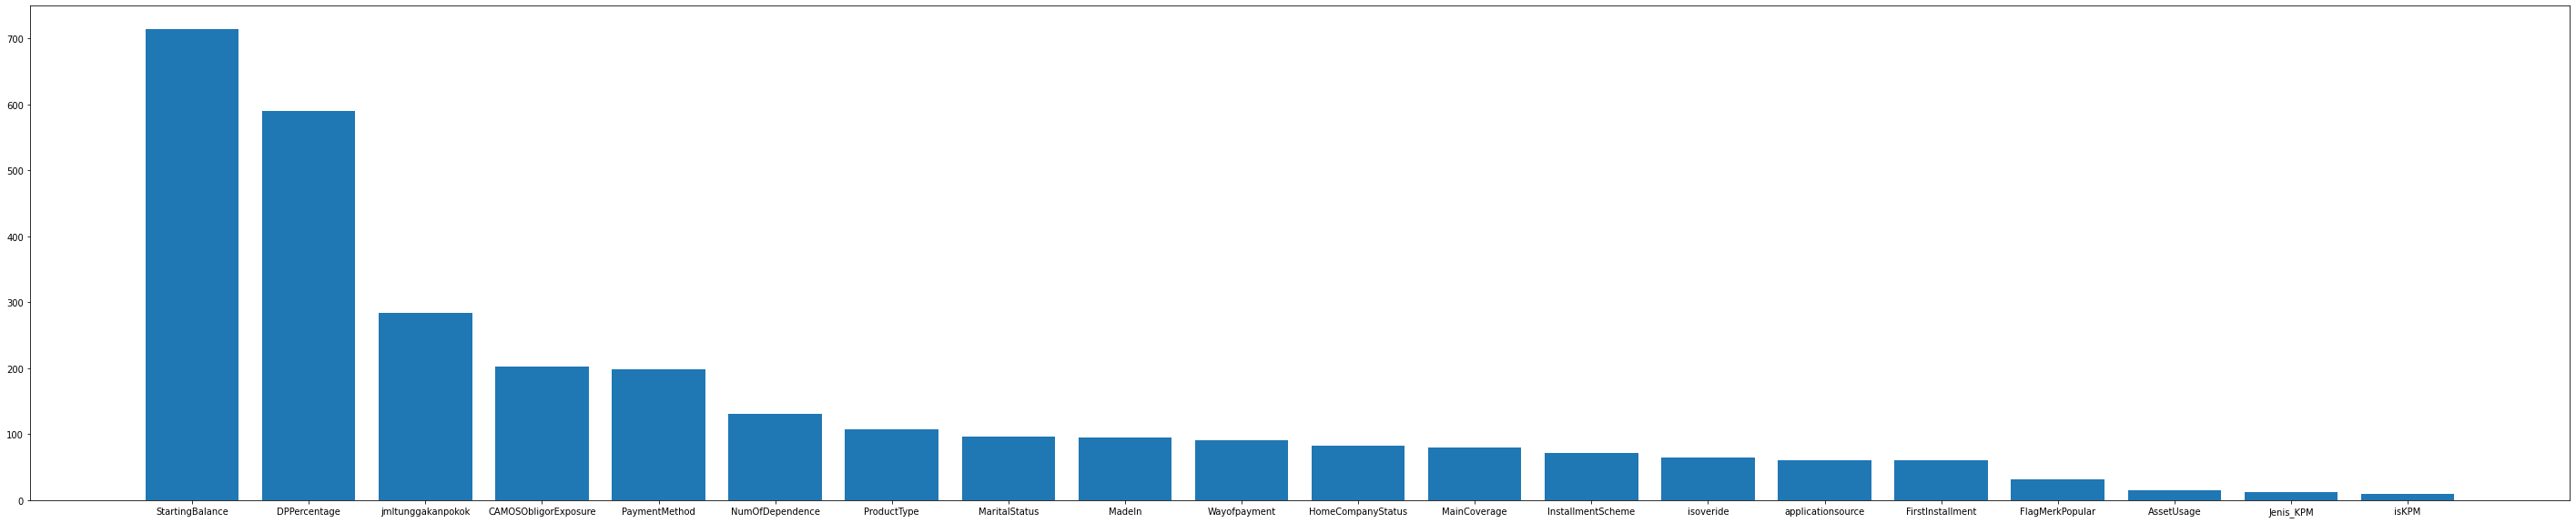

In [55]:
import matplotlib.pyplot as plt
names = list(fimpor.keys())
values = list(fimpor.values())
plt.subplots(figsize=(50,10))
plt.bar(range(len(fimpor)), values, tick_label=names)
plt.show()

In [56]:
#variance threshold drop
vt_drop1=X_train[cats_cols].loc[:,~model[0].transformers_[1][1][2].get_support()].columns
vt_drop2=X_train[X_train[cats_cols].loc[:,model[0].transformers_[1][1][2].get_support()].columns].loc[:,
            ~model[0].transformers_[1][1][3].get_support()].columns

#categorical feature yang tidak di drop di vt save di kats_cols
kats_cols=list(X_train[X_train[cats_cols].loc[:,model[0].transformers_[1][1][2].get_support()].columns].loc[:,
            model[0].transformers_[1][1][3].get_support()].columns)

#feature num dan kat sementara (setelah vt dan sebelum dropcorr)
dict_feature={k: v for v, k in enumerate(pd.DataFrame(model[0].transform(X_train),columns=num_cols+kats_cols).columns)}
dict_feature = {value:key for key, value in dict_feature.items()}

#feature korelasi drop
koreldrop=list( dict_feature[i] for i in sorted(list(model[1].col_corr)))

#feature num dan kat sementara 2 (setelah korelasi dan sebelum kbest)
allfeat=[x for x in (num_cols+kats_cols) if x not in (list( (num_cols+kats_cols)[i] for i in sorted(list(
        model[1].col_corr))))]

#feature yang masuk Kbest
kbes=(pd.DataFrame(model[0:2].transform(X_train))).loc[:,model[2].get_support()].columns
list( dict_feature[i] for i in sorted(list(kbes)))

#feature importance
fimpor = dict(zip(list( dict_feature[i] for i in sorted(list(kbes))), list(model[3].feature_importances_)))
fimpor=dict(sorted(fimpor.items(), key=lambda item: item[1], reverse=True))

In [57]:
len(allfeat)

46

In [58]:
fimpor

{'StartingBalance': 714,
 'DPPercentage': 590,
 'jmltunggakanpokok': 284,
 'CAMOSObligorExposure': 203,
 'PaymentMethod': 198,
 'NumOfDependence': 131,
 'ProductType': 108,
 'MaritalStatus': 97,
 'MadeIn': 95,
 'Wayofpayment': 91,
 'HomeCompanyStatus': 83,
 'MainCoverage': 80,
 'InstallmentScheme': 72,
 'isoveride': 65,
 'applicationsource': 60,
 'FirstInstallment': 60,
 'FlagMerkPopular': 32,
 'AssetUsage': 15,
 'Jenis_KPM': 12,
 'isKPM': 10}

In [9]:
if (model_score.loc['ROC Value']['Best Score'] == 'GaussianNB'):
  best_model = models['GaussianNB']
  best_roc_value = model_score.loc['ROC Value']['GaussianNB']
  # best_preds = gs_preds

elif (model_score.loc['ROC Value']['Best Score'] == 'LogisticRegression'):
  best_model = models['LogisticRegression']
  best_roc_value = model_score.loc['ROC Value']['LogisticRegression']
  # best_preds = lr_preds

elif (model_score.loc['ROC Value']['Best Score'] == 'RandomForestClassifier'):
  best_model = models['RandomForestClassifier']
  best_roc_value = model_score.loc['ROC Value']['RandomForestClassifier']
  # best_preds = rf_preds

elif (model_score.loc['ROC Value']['Best Score'] == 'XGBClassifier'):
  best_model = models['XGBClassifier']
  best_roc_value = model_score.loc['ROC Value']['XGBClassifier']
  # best_preds = xgb_preds
  
elif (model_score.loc['ROC Value']['Best Score'] == 'AdaBoostClassifier'):
  best_model = models['AdaBoostClassifier']
  best_roc_value = model_score.loc['ROC Value']['AdaBoostClassifier']
  # best_preds = abc_preds

elif (model_score.loc['ROC Value']['Best Score'] == 'LGBMClassifier'):
  best_model = models['LGBMClassifier']
  best_roc_value = model_score.loc['ROC Value']['LGBMClassifier']
  # best_preds = lgb_preds

In [10]:
def bestModel(params):
  if(best_model == models['GaussianNB']):
    clf = GaussianNB(**params)
  elif (best_model == models['LogisticRegression']):
    clf = LogisticRegression(**params,verbose=0)
  elif (best_model == models['RandomForestClassifier']):
    clf = RandomForestClassifier(**params)
  elif (best_model == models['XGBClassifier']):
    clf = xgb.XGBClassifier(**params)
  elif (best_model == models['AdaBoostClassifier']):
    clf = AdaBoostClassifier(**params)
  elif (best_model == models['LGBMClassifier']):
    clf = lgb.LGBMClassifier(**params)

  return clf

In [15]:
def objective (params, n_folds =2, X_train=X_train,y_train=y_train):
  clf = Pipeline(
    steps=[('dropcorr',DropCorrelation(0.9)),
           ('features',SelectKBest(mutual_info_classif, k=20)),
           ('models', bestModel(params))]
  )
  scores = cross_val_score(clf, preprocessor.fit_transform(X_train,y_train), y_train,cv=2,scoring='roc_auc')
  best_scores = max(scores)
  loss = 1-best_scores
  return{'loss':loss, 'params':params, 'status':STATUS_OK}

In [12]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

if (best_model == models['GaussianNB']):
  space={
      'var_smoothing' : hp.uniform('var_smoothing',np.logspace(0, -9, num=100))
  }
elif (best_model == models['LogisticRegression']):
  space = {
        'warm_start': hp.choice('warm_start', [True, False]),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'tol': hp.uniform('tol', 0.00001, 0.0001),
        'C': hp.uniform('C', 0.05, 3),
        'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear','sag']),
        'max_iter': hp.choice('max_iter', range(1000, 5000)),
        'multi_class': 'auto',
        'class_weight': hp.choice('class_weight',[None,'balanced'])
        }
elif (best_model == models['RandomForestClassifier']):
  space = {
        'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 1, 10, 1),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', range(10, 1000))
    }
elif (best_model == models['XGBClassifier']):
  space = {
        'booster': hp.choice('booster', ['gbtree','gblinear','dart']),
        'max_depth': hp.choice('max_depth', np.arange(1, 10, dtype=int)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'gamma': hp.uniform('gamma', 0, 1),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1),
        'scale_pos_weight': hp.quniform('scale_pos_weight', 1,8,1),
        'subsample' : hp.uniform('subsample',0.3,0.8),
        'colsample_bytree' : hp.uniform('colsample_bytree',0.3,0.8),
        'class_weight': hp.choice('class_weight',[None,'balanced'])
    }
elif (best_model == models['AdaBoostClassifier']):
  space = {
        'n_estimators': hp.choice('n_estimators', range(500, 1000)),
        'learning_rate' : hp.uniform('learning_rate', 0.01, 1)
    }
elif (best_model == models['LGBMClassifier']):
  space = {
        'is_unbalance': hp.choice('is_unbalance', [True, False]),
        'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'boosting_type': hp.choice('boosting_type', ['gbdt','dart','goss']),
        'num_leaves': hp.choice('num_leaves', np.arange(30, 150, dtype=int)),
        'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
        'max_bin': hp.choice('max_bin', np.arange(50, 500, dtype=int)),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
    }

In [16]:
tpe_algor = tpe.suggest
trials = Trials()
best = fmin(fn=objective, space = space,algo=tpe.suggest,max_evals=1, trials = trials)
trials_dict = sorted(trials.results, key = lambda x: x['loss']) 
hyp_df = pd.DataFrame(trials_dict)
best_hp = hyp_df.loc[0,'params']
hp_model = bestModel(best_hp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:30<00:00, 210.55s/trial, best loss: 0.21800292877026384]
